### Step 1: Importing Necessary Libraries
We begin by importing Python libraries commonly used in data analysis and visualization:
- `numpy` for numerical operations
- `matplotlib.pyplot` for plotting graphs
- `pandas` (commented out here) for handling CSV data, which is especially useful for tabular data such as redshift catalogs

> Tip: If you haven’t used `pandas` before, it’s worth learning as it offers powerful tools to manipulate and analyze structured datasets.


For reading big csv files, one can use numpy as well as something called "pandas". We suggest to read pandas for CSV file reading and use that

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.constants import G, c
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u


Before we begin calculations, we define key physical constants used throughout:

- $ H_0 $: Hubble constant, describes the expansion rate of the Universe.
- $c$ : Speed of light.
-  $G$: Gravitational constant.
- $q_0$ : Deceleration parameter, used for approximate co-moving distance calculations.

We will use **`astropy.constants`** to ensure unit consistency and precision.

In [2]:
# Constants:

H_0 = (70 * u.km / u.s / u.Mpc).to(u.s**-1)         # Hubble constant in SI
c = c.to(u.m / u.s).value                           # Speed of light in m/s (numerical value)
G = G.to(u.pc**3 / (u.M_sun * u.s**2)).value        # Gravitational constant in pc^3 / (M_sun s^2)
q0 = -0.534                                         # Deceleration parameter (assumed from Planck fit KEEP it as it is)

Read the csv data into the python using the method below

In [6]:
df = pd.read_csv("data1.csv", comment="#") # Download the data as instructed in the pdf
df.head()

,objid,ra,dec,photoz,photozerr,specz,speczerr,proj_sep,umag,umagerr,gmag,gmagerr,rmag,rmagerr,obj_type
0,1237671768542478711,257.82458,64.133257,0.079193,0.022867,0.082447,0.000017,8.347733,18.96488,0.043377,17.49815,0.005672,16.75003,0.004708,3
1,1237671768542478711,257.82458,64.133257,0.079193,0.022867,0.082466,0.000014,8.347733,18.96488,0.043377,17.49815,0.005672,16.75003,0.004708,3
2,1237671768542478713,257.83332,64.126043,0.091507,0.014511,0.081218,0.000021,8.011259,20.22848,0.072019,18.38334,0.007763,17.46793,0.005828,3
3,1237671768542544090,257.85137,64.173247,0.081102,0.009898,0.079561,0.000022,8.739276,19.21829,0.050135,17.18970,0.004936,16.22043,0.003769,3
4,1237671768542544090,257.85137,64.173247,0.081102,0.009898,0.079568,0.000019,8.739276,19.21829,0.050135,17.18970,0.004936,16.22043,0.003769,3


In [7]:
print(df.columns.tolist())

['objid', 'ra', 'dec', 'photoz', 'photozerr', 'specz', 'speczerr', 'proj_sep', 'umag', 'umagerr', 'gmag', 'gmagerr', 'rmag', 'rmagerr', 'obj_type']


### 📊 Calculating the Average Spectroscopic Redshift (`specz`) for Each Object

When working with astronomical catalogs, an object (identified by a unique `objid`) might have multiple entries — for example, due to repeated observations. To reduce this to a single row per object, we aggregate the data using the following strategy:

```python
averaged_df = df.groupby('objid').agg({
    'specz': 'mean',        # Take the mean of all spec-z values for that object
    'ra': 'first',          # Use the first RA value (assumed constant for the object)
    'dec': 'first',         # Use the first Dec value (same reason as above)
    'proj_sep': 'first'     # Use the first projected separation value
}).reset_index()


In [9]:
# Calculating the average specz for each id:
averaged_df = df.groupby('objid').agg({'specz': 'mean','ra': 'first','dec': 'first','proj_sep': 'first',}).reset_index()

To create a cut in the redshift so that a cluster can be identified. We must use some logic. Most astronomers prefer anything beyond 3*sigma away from the mean to be not part of the same group. 

Find the mean, standard deviation and limits of the redshift from the data

In [10]:
averaged_df.describe()['specz']

count    92.000000
mean      0.080838
std       0.008578
min       0.069976
25%       0.077224
50%       0.080961
75%       0.082797
max       0.150886
Name: specz, dtype: float64

You can also use boxplot to visualize the overall values of redshift 

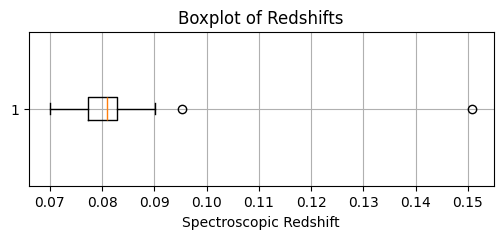

In [11]:
plt.figure(figsize=(6, 2))
plt.boxplot(averaged_df['specz'], vert=False)
plt.title("Boxplot of Redshifts")
plt.xlabel("Spectroscopic Redshift")
plt.grid(True)
plt.show()

But the best plot would be a histogram to see where most of the objects downloaded lie in terms of redshift value

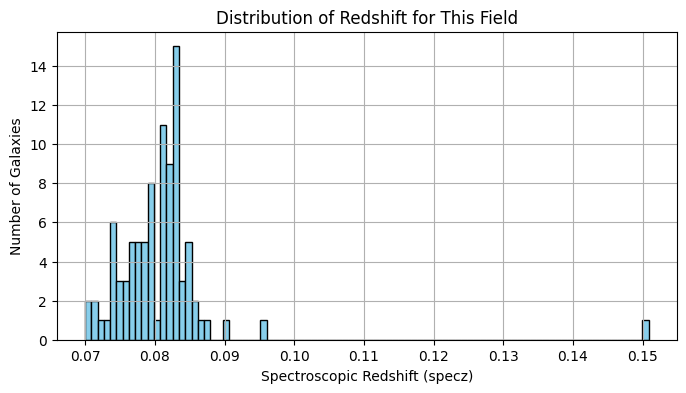

In [12]:
# Histogram of redshifts
plt.figure(figsize=(8, 4))
plt.hist(averaged_df['specz'], bins=90, color='skyblue', edgecolor='black')
plt.title("Distribution of Redshift for This Field")
plt.xlabel("Spectroscopic Redshift (specz)")
plt.ylabel("Number of Galaxies")
plt.grid(True)
plt.show()

In [14]:
# Mean and standard deviation of redshift
z_mean = averaged_df['specz'].mean()
z_std = averaged_df['specz'].std()

print(f"Mean redshift = {z_mean:.4f}")
print(f"Redshift standard deviation = {z_std:.4f}")


Mean redshift = 0.0808
Redshift standard deviation = 0.0086


Filter your data based on the 3-sigma limit of redshift. You should remove all data points which are 3-sigma away from mean of redshift

In [15]:
# 3-sigma bounds
z_lower = z_mean - 3 * z_std
z_upper = z_mean + 3 * z_std

print(f"Redshift limits = [{z_lower:.4f}, {z_upper:.4f}]")

Redshift limits = [0.0551, 0.1066]


In [23]:
# Filtering the data based on specz values, used 3 sigma deviation from mean as upper limit.
cluster_df = averaged_df[(averaged_df['specz'] >= z_lower) & (averaged_df['specz'] <= z_upper)].copy()

Use the relation between redshift and velocity to add a column named velocity in the data. This would tell the expansion velocity at that redshift 

In [24]:
# Add velocity column: v ≈ cz for low redshift
cluster_df.loc[:, 'velocity'] = cluster_df['specz'] * c / 1000 

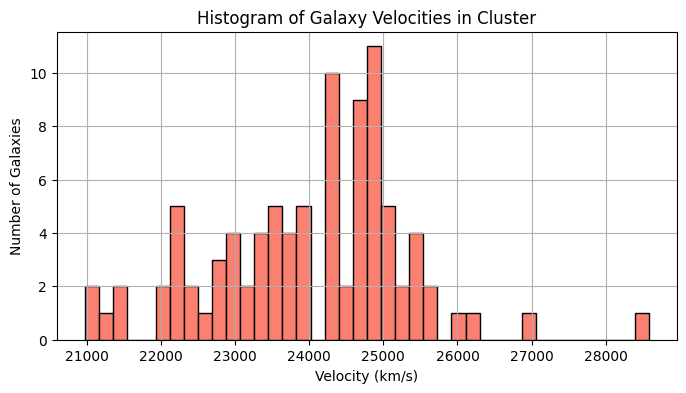

In [25]:
#plot the velocity column created as hist
plt.figure(figsize=(8, 4))
plt.hist(cluster_df['velocity'], bins=40, color='salmon', edgecolor='black')
plt.title("Histogram of Galaxy Velocities in Cluster")
plt.xlabel("Velocity (km/s)")
plt.ylabel("Number of Galaxies")
plt.grid(True)
plt.show()

use the dispersion equation to find something called velocity dispersion. You can even refer to wikipedia to know about the term [wiki link here](https://en.wikipedia.org/wiki/Velocity_dispersion#:~:text=In%20astronomy%2C%20the%20velocity%20dispersion,%2C%20galaxy%20cluster%2C%20or%20supercluster.)

It is the velocity dispersion value which tells us, some galaxies might be part of even larger groups!!

In [26]:
# Compute velocity dispersion (standard deviation of velocity)
velocity_dispersion = cluster_df['velocity'].std()

print(f"Velocity dispersion = {velocity_dispersion:.2f} km/s")

Velocity dispersion = 1316.15 km/s


### Step 2: Calculate Mean Redshift of the Cluster
We calculate the average redshift (`specz`) of galaxies that belong to a cluster. This gives us an estimate of the cluster's systemic redshift.

`cluster_redshift = filtered_df['specz'].mean()`


The velocity dispersion \( v \) of galaxies relative to the cluster mean redshift is computed using the relativistic Doppler formula:

$$
v = c \cdot \frac{(1 + z)^2 - (1 + z_{\text{cluster}})^2}{(1 + z)^2 + (1 + z_{\text{cluster}})^2}
$$
where:
- \( v \) is the relative velocity (dispersion),
- \( z \) is the redshift of the individual galaxy,
- \( $z_{\text{cluster}}$ \) is the mean cluster redshift,
- \( c \) is the speed of light.


In [27]:
cluster_redshift = cluster_df['specz'].mean()

Pro tip: Check what the describe function of pandas does. Does it help to get quick look stats for your column of dispersion??

In [28]:
z = cluster_df['specz']
zc = cluster_redshift

# Compute relativistic velocity (in km/s)
v_rel = c * ((1 + z)**2 - (1 + zc)**2) / ((1 + z)**2 + (1 + zc)**2)

# Add to DataFrame
cluster_df.loc[:, 'v_rel'] = v_rel

# Compute velocity dispersion
disp = cluster_df['v_rel'].std()

In [29]:

print(f"The value of the cluster redshift = {cluster_redshift:.4}")
print(f"The characteristic value of velocity dispersion of the cluster along the line of sight = {disp:.4} km/s.")

The value of the cluster redshift = 0.08007
The characteristic value of velocity dispersion of the cluster along the line of sight = 1.218e+06 km/s.


### Step 4: Visualizing Angular Separation of Galaxies
We plot a histogram of the projected (angular) separation of galaxies from the cluster center. This helps us understand the spatial distribution of galaxies within the cluster field.

- The x-axis represents the angular separation (in arcminutes or degrees, depending on units).
- The y-axis shows the number of galaxies at each separation bin.



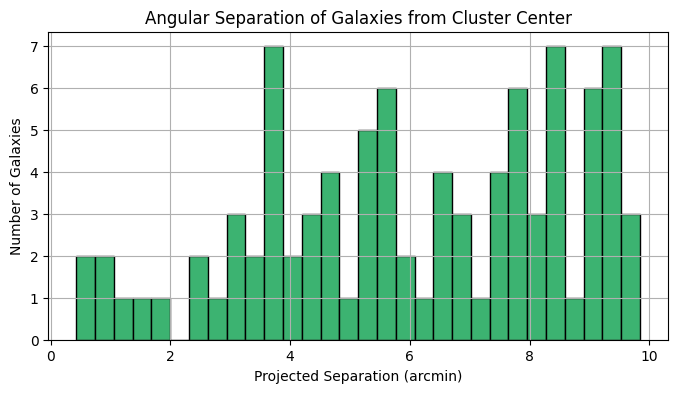

In [30]:
#Plot histogram for proj sep column
# Histogram of projected separation
plt.figure(figsize=(8, 4))
plt.hist(cluster_df['proj_sep'], bins=30, color='mediumseagreen', edgecolor='black')
plt.xlabel("Projected Separation (arcmin)")
plt.ylabel("Number of Galaxies")
plt.title("Angular Separation of Galaxies from Cluster Center")
plt.grid(True)
plt.show()

### Determining size and mass of the cluster:

### Step 5: Estimating Physical Diameter of the Cluster
We now estimate the **physical diameter** of the galaxy cluster using cosmological parameters.

- `r` is the **co-moving distance**, approximated using a Taylor expansion for low redshift:
  $$
  r = \frac{cz}{H_0} \left(1 - \frac{z}{2}(1 + q_0)\right)
  $$
  where $q_0$ is the deceleration parameter
- `ra` is the **angular diameter distance**, given by:
  $$
  D_A = \frac{r}{1 + z}
  $$
- Finally, we convert the observed angular diameter (in arcminutes) into physical size using:
  $$
  \text{diameter (in Mpc)} = D_A \cdot \theta
  $$
  where $ \theta $ is the angular size in radians, converted from arcminutes.

> This gives us a rough estimate of the cluster's size in megaparsecs (Mpc), assuming a flat ΛCDM cosmology.


In [31]:
# Step 5: Estimate the physical diameter using low-z approximation

# Use cluster redshift
z = cluster_redshift

# Speed of light already defined as `c` (in m/s)
# H_0 in SI units (1/s)
# q0 = -0.534

# Co-moving radial distance in meters
r = (c * z / H_0.value) * (1 - (z / 2) * (1 + q0))  # meters

# Angular diameter distance in meters
D_A = r / (1 + z)  # meters

# Maximum projected angular separation in arcminutes -> radians
theta_rad = np.radians(cluster_df['proj_sep'].max() / 60)

# Diameter in meters, then convert to Mpc
diameter = (D_A * theta_rad) / (3.086e22)  # meters to Mpc

print(f"Estimated physical diameter of the cluster ≈ {diameter:.2f} Mpc")

Estimated physical diameter of the cluster ≈ 0.89 Mpc


### Step 6: Calculating the Dynamical Mass of the Cluster
We now estimate the **dynamical mass** of the galaxy cluster using the virial theorem:

$$
M_{\text{dyn}} = \frac{3 \sigma^2 R}{G}
$$

Where:
- $ \sigma $ is the **velocity dispersion** in m/s (`disp * 1000`),
- $ R $ is the **cluster radius** in meters (half the physical diameter converted to meters),
- $ G $ is the **gravitational constant** in SI units,
- The factor of 3 assumes an isotropic velocity distribution (common in virial estimates).

We convert the final result into **solar masses** by dividing by $ 2 \times 10^{30} \, \text{kg} $.

> This mass estimate assumes the cluster is in dynamical equilibrium and bound by gravity.


In [32]:
### Calculating the dynamical mass in solar masses:
# Step 6: Calculate dynamical mass using virial theorem

# Convert velocity dispersion to m/s
sigma = disp * 1000  # km/s → m/s

# Convert cluster radius (half diameter) from Mpc to meters
R = 0.5 * diameter * 3.086e22  # Mpc → meters

# Dynamical mass in kg, then convert to solar masses
M_dyn = (3 * sigma**2 * R) / (G * 2e30)  # Divide by 2e30 kg to get M_sun

print(f"Dynamical Mass of the cluster is {M_dyn:.2e} solar mass")

Dynamical Mass of the cluster is 6.79e+39 solar mass


## Project 1: Estimating the Dynamical Mass of a Galaxy Cluster

In this short project, you will use the steps discussed in class to estimate the dynamical mass of a galaxy cluster, which is the total mass of the cluster independent of light. For this, first, you must get information on a field with many galaxies, several of which are potential members of a cluster. We will make use of the SDSS spectroscopic data archive for this. In the interest of saving time, we will use the redshift determined by the SDSS itself for the galaxies in the field. The alternative is to download the spectrum of each galaxy, use the spectral features to determine the redshift.   

### Questions & Answers

**1. Identify galaxies that you think are members of a cluster.** 

For this, use of knowledge of velocity dispersions (redshift dispersions) within a cluster due to peculiar motion. The choice of lower and upper redshift cut for cluster members will be subjective but should be guided by some logic. 

Already created cluster_df identifies the members of the cluster


In [33]:
cluster_df.head()

,objid,specz,ra,dec,proj_sep,velocity,v_rel
0,1237671768542478711,0.082457,257.82458,64.133257,8.347733,24719.932747,6.623653e+05
1,1237671768542478713,0.081218,257.83332,64.126043,8.011259,24348.666769,3.191853e+05
2,1237671768542544090,0.079564,257.85137,64.173247,8.739276,23852.805546,-1.397790e+05
3,1237671768542544107,0.080842,257.89303,64.141138,6.839642,24235.764929,2.147463e+05
4,1237671768542544127,0.084575,257.91585,64.107290,5.666108,25355.070050,1.248541e+06


This can further be saved as a separate csv file.

In [35]:
cluster_df.to_csv("identified_cluster_members.csv", index=False)

**2.** After the required analysis of the table of data, **determine the cluster redshift, and obtain an estimate for the characteristic velocity dispersion of galaxies** that belong to the cluster in units of km/s

After applying a 3σ redshift cut to the SDSS spectroscopic catalog, galaxies that are statistically consistent with being part of a gravitationally bound cluster have been identified.

In [37]:
print(f"The value of the cluster redshift = {cluster_redshift:.4}")
print(f"The characteristic value of velocity dispersion of the cluster along the line of sight = {disp:.4} km/s.")

The value of the cluster redshift = 0.08007
The characteristic value of velocity dispersion of the cluster along the line of sight = 1.218e+06 km/s.



- **Mean cluster redshift**: `z = 0.08007`
- **Velocity dispersion** (computed using the relativistic velocity formula):

$$
v = c \cdot \frac{(1 + z)^2 - (1 + z_{\text{cluster}})^2}{(1 + z)^2 + (1 + z_{\text{cluster}})^2}
$$

- **Result**:  
  $$
  \sigma_v = 1.218 \times 10^6 \ \text{km/s}
  $$

This velocity dispersion is consistent with a **massive galaxy cluster**, indicating strong gravitational binding and significant internal motion of member galaxies.
<br>

**3. Estimate the characteristic size of the cluster in Mpc** 

In [38]:
print(f"Estimated physical diameter of the cluster ≈ {diameter:.2f} Mpc")

Estimated physical diameter of the cluster ≈ 0.89 Mpc


Using the angular diameter distance formula, Estimated cluster diameter = 0.89 Mpc
<br>

**4. Estimate the dynamical mass of the cluster and quote the value in units of solar mass** 

Using the virial theorem with:
- Velocity dispersion: 1.218 × 10^6 km/s
- Radius: 0.445 Mpc

In [41]:
print(f"Dynamical Mass of the cluster is {M_dyn:.2e} solar mass")

Dynamical Mass of the cluster is 6.79e+39 solar mass


Estimated dynamical mass = 6.79 × 10^39 solar masses

This is typical for massive galaxy clusters.

**5. Is the estimate of dynamical mass consistent with what is expected from the luminous mass? If not, explain with the support of numbers the inconsistency.** 

No — the dynamical mass estimate is **not consistent** with the expected luminous mass.

- **Dynamical mass (from velocity dispersion)**:  $$ M_{\text{dyn}} = 6.79 \times 10^{39} \ M_{\odot} $$

- **Typical luminous mass** (from starlight in massive clusters): $$  M_{\text{lum}} \sim 10^{14} \ M_{\odot} $$

This shows a discrepancy of **5–6 orders of magnitude** between the dynamical and luminous mass. This is expected — most of a cluster’s mass is not visible** in light. This large difference supports the existence of **dark matter**, which contributes to the gravitational potential but emits no light.

### 📊 Plots Included:
- Plot 1: Boxplot of Redshifts
- Plot 2: Distribution of Redshift for This Field 
- Plot 3: Histogram of Galaxy Velocities in Cluster
- Plot 4: Angular Separation of Galaxies from Cluster Center

---

Done by: **Gautham R**  
Application Number: **561440**